# **Parallel Node Execution:**

Let's see how we can set up and execute nodes in parallel within a LangGraph workflow, introducing the concept of fan-out and fan-in. By running nodes in parallel, we can speed up workflows, especially useful when performing independent tasks that can happen simultaneously.

### **Set up Everything:**

In [1]:
%%capture --no-stderr
%pip install -qU langgraph langchain-google-genai langchain_core langchain_community

## **Creating a Normal Workflow:**

In [4]:
from typing import Any
from typing_extensions import TypedDict

class State(TypedDict):
    # The operator.add reducer fn makes this append-only
    state: str

class ReturnNodeValue:
    def __init__(self, node_secret: str):
        self._value = node_secret

    def __call__(self, state: State) -> Any:
        print(f"Adding {self._value} to {state['state']}")
        return {"state": [self._value]}

* **Define State:** A typed dictionary where state holds a string list.

* **ReturnNodeValue:** This class simulates node execution by appending a string (like "I'm A", "I'm B") to the state. When called, it prints the current update and returns the updated state.

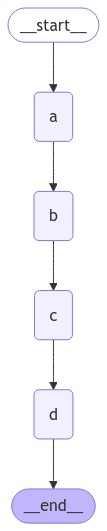

In [5]:
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display

# Add nodes
builder = StateGraph(State)

# Initialize each node with node_secret
builder.add_node("a", ReturnNodeValue("I'm A"))
builder.add_node("b", ReturnNodeValue("I'm B"))
builder.add_node("c", ReturnNodeValue("I'm C"))
builder.add_node("d", ReturnNodeValue("I'm D"))

# Flow
builder.add_edge(START, "a")
builder.add_edge("a", "b")
builder.add_edge("b", "c")
builder.add_edge("c", "d")
builder.add_edge("d", END)
graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

* **Define Nodes:** Each node is assigned a label (e.g., a, b) and a ReturnNodeValue instance with a unique message.

* **Define Flow:** The nodes are connected in sequence (a -> b -> c -> d). START is the initial point, and END marks the end.

**We overide the state as expected:**

In [6]:
graph.invoke({"state": []})

Adding I'm A to []
Adding I'm B to ["I'm A"]
Adding I'm C to ["I'm B"]
Adding I'm D to ["I'm C"]


{'state': ["I'm D"]}

## **Introducing Parallelism with Fan-Out and Fan-In:**

The main goal here is to create a workflow where nodes b and c run in parallel, both updating the state, and then both feed into node d.

In [7]:
builder = StateGraph(State)

# Initialize each node with node_secret
builder.add_node("a", ReturnNodeValue("I'm A"))
builder.add_node("b", ReturnNodeValue("I'm B"))
builder.add_node("c", ReturnNodeValue("I'm C"))
builder.add_node("d", ReturnNodeValue("I'm D"))

# Flow
builder.add_edge(START, "a")
builder.add_edge("a", "b")
builder.add_edge("a", "c")
builder.add_edge("b", "d")
builder.add_edge("c", "d")
builder.add_edge("d", END)
graph = builder.compile()

* **Parallel Execution Setup:** Nodes b and c both follow a, meaning they will execute in parallel after node a finishes. They both feed into node d, so d waits for both b and c to finish before executing.

* **Error Due to State Conflicts:** If nodes b and c try to write to the same state key (state) in parallel, LangGraph raises an InvalidUpdateError since the same key cannot be updated concurrently without a reducer function to handle it.

In [8]:
from langgraph.errors import InvalidUpdateError
try:
    graph.invoke({"state": []})
except InvalidUpdateError as e:
    print(f"An error occurred: {e}")

Adding I'm A to []
Adding I'm B to ["I'm A"]
Adding I'm C to ["I'm A"]
An error occurred: At key 'state': Can receive only one value per step. Use an Annotated key to handle multiple values.
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/INVALID_CONCURRENT_GRAPH_UPDATE


## **Using a Reducer Function:**



When using fan out, we need to be sure that we are using a reducer if steps are writing to the same the channel / key.

As we touched on in Module 2, operator.add is a function from Python's built-in operator module.

When operator.add is applied to lists, it performs list concatenation.

In [9]:
import operator
from typing import Annotated

class State(TypedDict):
    # The operator.add reducer fn makes this append-only
    state: Annotated[list, operator.add]

# Add nodes
builder = StateGraph(State)

# Initialize each node with node_secret
builder.add_node("a", ReturnNodeValue("I'm A"))
builder.add_node("b", ReturnNodeValue("I'm B"))
builder.add_node("c", ReturnNodeValue("I'm C"))
builder.add_node("d", ReturnNodeValue("I'm D"))

# Flow
builder.add_edge(START, "a")
builder.add_edge("a", "b")
builder.add_edge("a", "c")
builder.add_edge("b", "d")
builder.add_edge("c", "d")
builder.add_edge("d", END)
graph = builder.compile()

graph.invoke({"state": []})

Adding I'm A to []
Adding I'm B to ["I'm A"]
Adding I'm C to ["I'm A"]
Adding I'm D to ["I'm A", "I'm B", "I'm C"]


{'state': ["I'm A", "I'm B", "I'm C", "I'm D"]}

* **Reducer Function:** operator.add is used as a reducer, which concatenates lists. When state is a list, operator.add appends updates from both b and c to it.

* **Parallel Updates without Conflict:** Using operator.add allows both b and c to write to state simultaneously without error.

In [10]:
graph.invoke({"state": []})

Adding I'm A to []
Adding I'm B to ["I'm A"]
Adding I'm C to ["I'm A"]
Adding I'm D to ["I'm A", "I'm B", "I'm C"]


{'state': ["I'm A", "I'm B", "I'm C", "I'm D"]}

## **Waiting for Nodes to Complete:**

Now, lets consider a case where one parallel path has more steps than the other one.

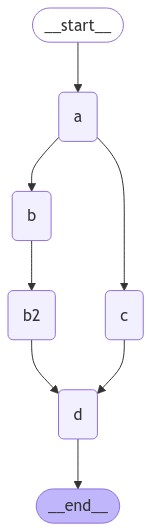

In [11]:
builder = StateGraph(State)

# Initialize each node with node_secret
builder.add_node("a", ReturnNodeValue("I'm A"))
builder.add_node("b", ReturnNodeValue("I'm B"))
builder.add_node("b2", ReturnNodeValue("I'm B2"))
builder.add_node("c", ReturnNodeValue("I'm C"))
builder.add_node("d", ReturnNodeValue("I'm D"))

# Flow
builder.add_edge(START, "a")
builder.add_edge("a", "b")
builder.add_edge("a", "c")
builder.add_edge("b", "b2")
builder.add_edge(["b2", "c"], "d")
builder.add_edge("d", END)
graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

* **Different Path Lengths:** Here, b2 is an additional step that only b follows. The graph will wait for both b2 and c to finish before proceeding to d.

* **Synchronization:** d does not execute until both paths (b2 and c) are complete, ensuring no data inconsistency.

In [12]:
graph.invoke({"state": []})

Adding I'm A to []
Adding I'm B to ["I'm A"]
Adding I'm C to ["I'm A"]
Adding I'm B2 to ["I'm A", "I'm B", "I'm C"]
Adding I'm D to ["I'm A", "I'm B", "I'm C", "I'm B2"]


{'state': ["I'm A", "I'm B", "I'm C", "I'm B2", "I'm D"]}

## **Custom Reducer to Control Update Order:**

As we saw above, the flow in which state is updating is not in our control.

if we want to control the flow in which the state is being updated, we can use a custom reducer.

In [13]:
def sorting_reducer(left, right):
    """ Combines and sorts the values in a list"""
    if not isinstance(left, list):
        left = [left]
    if not isinstance(right, list):
        right = [right]
    return sorted(left + right, reverse=False)

* **Sorting Reducer:** This custom reducer ensures that updates to state are sorted alphabetically. When b2 and c write to state, this reducer sorts the values in ascending order.

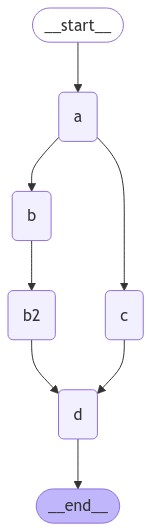

In [14]:
class State(TypedDict):
    # sorting_reducer will sort the values in state
    state: Annotated[list, sorting_reducer]

# Add nodes
builder = StateGraph(State)

# Initialize each node with node_secret
builder.add_node("a", ReturnNodeValue("I'm A"))
builder.add_node("b", ReturnNodeValue("I'm B"))
builder.add_node("b2", ReturnNodeValue("I'm B2"))
builder.add_node("c", ReturnNodeValue("I'm C"))
builder.add_node("d", ReturnNodeValue("I'm D"))

# Flow
builder.add_edge(START, "a")
builder.add_edge("a", "b")
builder.add_edge("a", "c")
builder.add_edge("b", "b2")
builder.add_edge(["b2", "c"], "d")
builder.add_edge("d", END)
graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [15]:
graph.invoke({"state": []})

Adding I'm A to []
Adding I'm B to ["I'm A"]
Adding I'm C to ["I'm A"]
Adding I'm B2 to ["I'm A", "I'm B", "I'm C"]
Adding I'm D to ["I'm A", "I'm B", "I'm B2", "I'm C"]


{'state': ["I'm A", "I'm B", "I'm B2", "I'm C", "I'm D"]}